# Homework 3 - Berkeley STAT 157

Handout 2/5/2019, due 2/12/2019 by 4pm in Git by committing to your repository.

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named homework3.ipynb and homework3.pdf. You can export your notebook to a pdf either by File -> Download as -> PDF via Latex (you may need Latex installed), or by simply printing to a pdf from your browser (you may want to do File -> Print Preview in jupyter first). Please don't change the filename.**       

In [145]:
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.
1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

1.4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 

![alt text](IMG_0054.jpg)

# 2. Logistic Regression and Autograd

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

In [146]:
def loss(y,o):
    loss = gluon.loss.LogisticLoss()
    return loss(o,y)
o = nd.arange(-5, 6)
y_1 = nd.ones(o.shape)
l1= loss(y_1, o)
l1


[5.0067153  4.01815    3.0485873  2.126928   1.3132617  0.6931472
 0.3132617  0.12692802 0.04858735 0.01814993 0.00671535]
<NDArray 11 @cpu(0)>

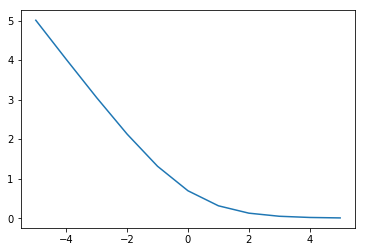

In [147]:
plt.plot(o.asnumpy(), l1.asnumpy())

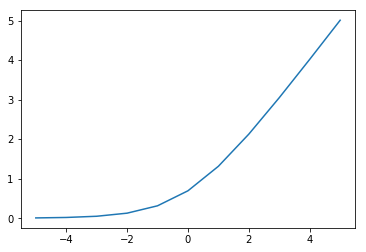

In [148]:
y_2 = y_1 * -1
l2 = loss(y_2, o)
plt.plot(o.asnumpy(),l2.asnumpy())


[-0.9933072  -0.98201376 -0.95257413 -0.8807971  -0.7310586  -1.
 -0.26894143 -0.11920293 -0.04742587 -0.01798621 -0.00669285]
<NDArray 11 @cpu(0)>

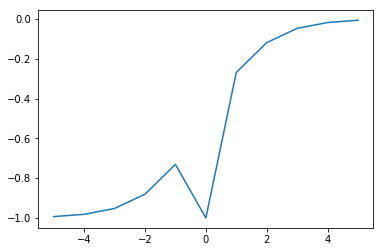

In [149]:
o.attach_grad()
with autograd.record():
    l = loss(y_1, o)
l.backward()
plt.plot(o.asnumpy(),o.grad.asnumpy())
o.grad


[0.00669285 0.01798621 0.04742587 0.11920293 0.26894143 0.
 0.7310586  0.8807971  0.95257413 0.98201376 0.9933072 ]
<NDArray 11 @cpu(0)>

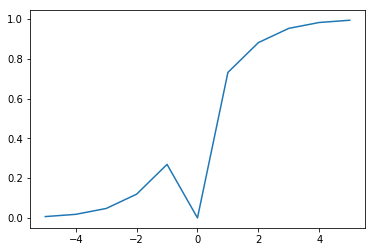

In [150]:
o.attach_grad()
with autograd.record():
    l = loss(y_2, o)
l.backward()
plt.plot(o.asnumpy(),o.grad.asnumpy())
o.grad

# 3. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [54]:
current = nd.array([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = nd.array([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

batch_size = 20
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(current, voltage),
                                   batch_size=batch_size)

def net1(current):
    current2 = current * current
    return current2 * q + current * r + c

def net2(current):
    return current * r + c

def net3(current):
    return current * r

def square_loss(yhat, y):
    return nd.mean((yhat - y) ** 2)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

# 1.
Used 10000 epochs for training with net 1

In [96]:
q = nd.random_normal(shape=(1,1))
r = nd.random_normal(shape=(1, 1))
c = nd.random_normal(shape=1)
params = [q, r, c]

for param in params:
    param.attach_grad()

def net1(current):
    current2 = current * current
    return current2 * q + current * r + c

epochs = 10000
learning_rate = .0005
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net1(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / 20)

2109.99765625
1376.87216796875
922.078125
639.8109375
464.487646484375
355.4563232421875
287.518408203125
245.054296875
218.382177734375
201.50078125
190.68997802734376
183.6438720703125
178.933203125
175.67193603515625
173.3109130859375
171.5096923828125
170.05726318359376
168.82275390625
167.7251220703125
166.7140625
165.7583740234375
164.83876953125
163.9432861328125
163.064404296875
162.19752197265626
161.3397705078125
160.48941650390626
159.64525146484374
158.8066162109375
157.97308349609375
157.14434814453125
156.32022705078126
155.50057373046874
154.6853515625
153.874462890625
153.06787109375
152.2655517578125
151.4674560546875
150.6735595703125
149.88382568359376
149.0982666015625
148.3168212890625
147.53951416015624
146.7662841796875
145.9970947265625
145.23193359375
144.4708251953125
143.71373291015624
142.9605712890625
142.21138916015624
141.4661376953125
140.72479248046875
139.9873779296875
139.25380859375
138.52408447265626
137.7982177734375
137.076171875
136.3578979492187

14.556367492675781
14.481779479980469
14.407600402832031
14.333792114257813
14.260391235351562
14.187361145019532
14.1147216796875
14.042465209960938
13.970588684082031
13.899076843261719
13.827951049804687
13.75719757080078
13.686808776855468
13.616795349121094
13.547160339355468
13.477880859375
13.408963012695313
13.340415954589844
13.27222137451172
13.204379272460937
13.136911010742187
13.069784545898438
13.003018188476563
12.936599731445312
12.870527648925782
12.804800415039063
12.739424896240234
12.674383544921875
12.609690093994141
12.54534454345703
12.48132781982422
12.417647552490234
12.354301452636719
12.29128646850586
12.228605651855469
12.16624755859375
12.104225158691406
12.042529296875
11.981159973144532
11.920097351074219
11.85937271118164
11.79895248413086
11.738859558105469
11.679084777832031
11.619612884521484
11.56045913696289
11.501615142822265
11.44308853149414
11.384857177734375
11.32693862915039
11.269319152832031
11.212003326416015
11.154988098144532
11.098278808

1.4526507377624511
1.446867084503174
1.4411134719848633
1.435394287109375
1.4297004699707032
1.424039649963379
1.4184039115905762
1.4128039360046387
1.4072296142578125
1.4016855239868165
1.3961694717407227
1.3906825065612793
1.3852198600769043
1.379790687561035
1.3743911743164063
1.3690173149108886
1.3636724472045898
1.358355712890625
1.3530667304992676
1.347807025909424
1.3425707817077637
1.3373651504516602
1.3321855545043946
1.3270327568054199
1.3219052314758302
1.3168106079101562
1.311735248565674
1.306691551208496
1.3016695976257324
1.2966769218444825
1.2917104721069337
1.286768913269043
1.2818554878234862
1.2769668579101563
1.2721011161804199
1.2672625541687013
1.2624524116516114
1.257665252685547
1.2529024124145507
1.2481658935546875
1.2434550285339356
1.2387675285339355
1.2341034889221192
1.2294651985168457
1.2248524665832519
1.2202618598937989
1.2156970024108886
1.211149024963379
1.2066325187683105
1.2021356582641602
1.1976643562316895
1.1932172775268555
1.188790225982666
1.184

0.4586521625518799
0.45804786682128906
0.4574435234069824
0.45684399604797366
0.45624771118164065
0.45565452575683596
0.4550626754760742
0.45447554588317873
0.45389108657836913
0.4533097267150879
0.452731990814209
0.45215578079223634
0.4515841007232666
0.4510143280029297
0.45044736862182616
0.449884033203125
0.44932098388671876
0.44876604080200194
0.4482105255126953
0.44765725135803225
0.44710693359375
0.44655795097351075
0.4460150718688965
0.44547419548034667
0.44493532180786133
0.4443985939025879
0.4438660144805908
0.44333562850952146
0.4428078651428223
0.44228415489196776
0.44176039695739744
0.4412400722503662
0.44072351455688474
0.44020853042602537
0.4396968841552734
0.43918652534484864
0.4386784553527832
0.43817453384399413
0.4376722812652588
0.43717374801635744
0.4366766929626465
0.43618249893188477
0.43569111824035645
0.43520102500915525
0.43471379280090333
0.43423027992248536
0.4337491035461426
0.433270263671875
0.43279237747192384
0.43231782913208006
0.43184576034545896
0.4313

0.34533843994140623
0.34527785778045655
0.34521660804748533
0.34515719413757323
0.3450955867767334
0.34503517150878904
0.34497666358947754
0.3449154615402222
0.3448559522628784
0.34479694366455077
0.34473793506622313
0.34467830657958987
0.34461963176727295
0.34456188678741456
0.3445042371749878
0.3444453001022339
0.34438903331756593
0.344329833984375
0.3442723512649536
0.34421558380126954
0.34415812492370607
0.3441009521484375
0.3440447568893433
0.34398784637451174
0.3439323902130127
0.34387574195861814
0.34382119178771975
0.3437643051147461
0.3437096834182739
0.3436543941497803
0.343598747253418
0.3435442686080933
0.3434893131256104
0.34343459606170657
0.34338085651397704
0.3433263063430786
0.34327263832092286
0.343218469619751
0.34316411018371584
0.34311187267303467
0.34305896759033205
0.3430037260055542
0.3429529666900635
0.34289870262145994
0.3428478240966797
0.34279475212097166
0.34274299144744874
0.3426907777786255
0.3426391124725342
0.3425870895385742
0.342536473274231
0.3424848

0.3301039934158325
0.33008131980895994
0.33005824089050295
0.3300352096557617
0.3300121307373047
0.3299887180328369
0.3299660921096802
0.329943323135376
0.3299201488494873
0.32989795207977296
0.32987442016601565
0.3298513889312744
0.3298290967941284
0.3298060655593872
0.32978320121765137
0.32976059913635253
0.3297381639480591
0.3297149181365967
0.32969279289245607
0.3296696901321411
0.3296469211578369
0.3296248197555542
0.329602575302124
0.32957911491394043
0.32955710887908934
0.3295352220535278
0.32951209545135496
0.3294888734817505
0.3294679164886475
0.3294446229934692
0.3294219493865967
0.3294007062911987
0.32937870025634763
0.3293550968170166
0.3293324947357178
0.32931087017059324
0.3292882442474365
0.329265832901001
0.32924423217773435
0.329221773147583
0.32919921875
0.3291774749755859
0.3291545152664185
0.3291333675384521
0.32911133766174316
0.3290884017944336
0.32906696796417234
0.32904484272003176
0.3290232181549072
0.3290005445480347
0.32897846698760985
0.32895698547363283
0.3

0.3210566282272339
0.32103743553161623
0.3210192918777466
0.3210001468658447
0.3209825992584229
0.32096500396728517
0.3209466218948364
0.3209272861480713
0.3209089994430542
0.3208897113800049
0.32087178230285646
0.32085223197937013
0.32083404064178467
0.3208165645599365
0.32079861164093015
0.32077980041503906
0.3207619428634644
0.3207423448562622
0.32072346210479735
0.3207050323486328
0.3206866502761841
0.32066855430603025
0.3206498384475708
0.3206321716308594
0.32061314582824707
0.32059516906738283
0.32057642936706543
0.3205580234527588
0.32053961753845217
0.3205214738845825
0.3205033540725708
0.32048442363739016
0.32046611309051515
0.3204479694366455
0.3204294204711914
0.3204104661941528
0.32039246559143064
0.3203746795654297
0.32035553455352783
0.3203378677368164
0.32031960487365724
0.32030067443847654
0.32028191089630126
0.3202639102935791
0.32024579048156737
0.320227313041687
0.32020866870880127
0.3201908588409424
0.3201723098754883
0.3201541185379028
0.3201345920562744
0.32011666

0.3134261131286621
0.3134071588516235
0.31339116096496583
0.3133727550506592
0.31335399150848386
0.3133368968963623
0.3133189916610718
0.31330127716064454
0.3132850408554077
0.3132664203643799
0.3132493495941162
0.3132318496704102
0.3132136583328247
0.31319615840911863
0.3131792783737183
0.3131610631942749
0.31314380168914796
0.3131268501281738
0.3131093978881836
0.31309032440185547
0.3130731821060181
0.3130561113357544
0.31303725242614744
0.31302127838134763
0.3130028247833252
0.31298532485961916
0.3129671573638916
0.31295070648193357
0.31293234825134275
0.31291496753692627
0.3128974437713623
0.3128795146942139
0.31286234855651857
0.3128439664840698
0.31282792091369627
0.3128089427947998
0.312791109085083
0.31277449131011964
0.3127570390701294
0.31273903846740725
0.31272130012512206
0.3127030849456787
0.3126869201660156
0.31266934871673585
0.31264989376068114
0.3126338243484497
0.3126158952713013
0.31259784698486326
0.3125805616378784
0.31256375312805174
0.3125458717346191
0.312528061

0.30575103759765626
0.3057345151901245
0.30571722984313965
0.30569982528686523
0.3056828260421753
0.3056661367416382
0.30564897060394286
0.3056319713592529
0.3056147575378418
0.305598521232605
0.3055805444717407
0.3055636644363403
0.3055462598800659
0.3055295467376709
0.3055125713348389
0.30549576282501223
0.30547873973846434
0.3054617643356323
0.30544447898864746
0.3054274320602417
0.30541000366210935
0.3053934574127197
0.30537712574005127
0.3053595066070557
0.30534210205078127
0.30532498359680177
0.3053086519241333
0.30529160499572755
0.30527434349060056
0.30525779724121094
0.30524065494537356
0.305223274230957
0.3052059173583984
0.30518934726715086
0.3051722049713135
0.30515503883361816
0.3051384210586548
0.3051215648651123
0.30510356426239016
0.3050873279571533
0.3050696611404419
0.3050537109375
0.3050361156463623
0.30501911640167234
0.30500178337097167
0.30498547554016114
0.30496830940246583
0.3049513101577759
0.3049341917037964
0.30491759777069094
0.3049003124237061
0.30488400459

0.2986271381378174
0.29861013889312743
0.29859397411346433
0.29857702255249025
0.2985605478286743
0.2985442399978638
0.29852750301361086
0.29851136207580564
0.2984952449798584
0.2984778881072998
0.298461389541626
0.2984447956085205
0.2984275817871094
0.29841148853302
0.2983946561813354
0.2983783006668091
0.29836134910583495
0.2983453035354614
0.2983299493789673
0.29831271171569823
0.2982959270477295
0.29827907085418703
0.298262357711792
0.2982458591461182
0.2982299327850342
0.29821195602416994
0.2981975317001343
0.29817953109741213
0.29816408157348634
0.2981463193893433
0.2981302261352539
0.2981128454208374
0.2980978012084961
0.29808075428009034
0.2980650901794434
0.2980475664138794
0.29803051948547366
0.2980145692825317
0.29799909591674806
0.29798140525817873
0.2979651212692261
0.29794812202453613
0.2979325294494629
0.29791650772094724
0.297898530960083
0.2978828907012939
0.2978661298751831
0.2978497505187988
0.29783339500427247
0.2978163242340088
0.29779980182647703
0.297783923149108

0.2911795377731323
0.2911642074584961
0.2911477565765381
0.2911315679550171
0.2911147356033325
0.29109940528869627
0.2910841703414917
0.2910678148269653
0.29105205535888673
0.29103496074676516
0.2910193920135498
0.2910027027130127
0.2909875392913818
0.2909712553024292
0.29095556735992434
0.29093916416168214
0.2909228801727295
0.2909075736999512
0.2908910036087036
0.2908747911453247
0.2908586263656616
0.29084322452545164
0.2908278703689575
0.29081101417541505
0.29079556465148926
0.2907788991928101
0.29076313972473145
0.29074649810791015
0.29073123931884765
0.2907142400741577
0.2906994342803955
0.29068214893341066
0.2906662464141846
0.2906517744064331
0.2906349658966064
0.2906190395355225
0.2906017780303955
0.290586519241333
0.29057118892669676
0.2905543804168701
0.2905391216278076
0.29052276611328126
0.2905065298080444
0.29049105644226075
0.29047489166259766
0.2904583692550659
0.2904427289962769
0.2904266357421875
0.29041008949279784
0.2903956651687622
0.29037954807281496
0.290363407135

0.28375222682952883
0.28373548984527586
0.2837213516235352
0.28370587825775145
0.2836894512176514
0.2836738348007202
0.28365910053253174
0.2836431980133057
0.2836273431777954
0.2836116075515747
0.2835962772369385
0.2835801601409912
0.2835655689239502
0.2835503339767456
0.2835336208343506
0.2835183620452881
0.28350300788879396
0.2834879159927368
0.28347268104553225
0.28345646858215334
0.28344144821166994
0.2834263801574707
0.28341021537780764
0.28339428901672364
0.28337950706481935
0.2833631753921509
0.28334760665893555
0.2833327531814575
0.2833171129226685
0.2833007574081421
0.28328642845153806
0.2832713842391968
0.28325533866882324
0.2832393407821655
0.2832243204116821
0.2832079648971558
0.28319315910339354
0.28317790031433104
0.2831618547439575
0.28314664363861086
0.28313145637512205
0.28311591148376464
0.2831000566482544
0.28308448791503904
0.2830686092376709
0.28305392265319823
0.28303825855255127
0.2830228328704834
0.28300702571868896
0.2829911708831787
0.28297626972198486
0.28296

0.2772320032119751
0.2772177219390869
0.2772026538848877
0.2771871566772461
0.2771724462509155
0.27715656757354734
0.27714176177978517
0.2771273136138916
0.27711172103881837
0.27709715366363524
0.27708187103271487
0.2770667552947998
0.2770524978637695
0.27703745365142823
0.27702155113220217
0.2770063877105713
0.27699096202850343
0.2769765377044678
0.276963210105896
0.2769466400146484
0.2769317150115967
0.2769162654876709
0.2769016265869141
0.27688710689544677
0.27687151432037355
0.276857328414917
0.27684199810028076
0.27682650089263916
0.2768118143081665
0.2767970561981201
0.2767815113067627
0.2767664432525635
0.27675182819366456
0.2767362117767334
0.27672157287597654
0.27670629024505616
0.27669100761413573
0.27667579650878904
0.2766615390777588
0.27664639949798586
0.2766313076019287
0.27661683559417727
0.27660164833068845
0.2765862464904785
0.2765707492828369
0.27655715942382814
0.2765412092208862
0.27652602195739745
0.2765113353729248
0.27649712562561035
0.27648191452026366
0.2764656

0.2706711530685425
0.27065701484680177
0.2706428289413452
0.2706275939941406
0.27061316967010496
0.2705988883972168
0.2705834865570068
0.2705696582794189
0.27055511474609373
0.27053978443145754
0.2705253839492798
0.2705104351043701
0.2704960346221924
0.27048230171203613
0.2704667091369629
0.27045207023620604
0.2704375982284546
0.27042288780212403
0.2704082250595093
0.27039380073547364
0.27037954330444336
0.2703641414642334
0.27034964561462405
0.27033557891845705
0.2703209638595581
0.2703064441680908
0.2702911376953125
0.27027599811553954
0.27026197910308836
0.27024800777435304
0.27023265361785886
0.2702184677124023
0.2702035427093506
0.2701887130737305
0.2701745510101318
0.2701597213745117
0.27014548778533937
0.2701306104660034
0.27011594772338865
0.2701016902923584
0.27008728981018065
0.27007231712341306
0.27005801200866697
0.2700422048568726
0.27002863883972167
0.27001395225524905
0.2699993133544922
0.26998534202575686
0.2699697971343994
0.26995625495910647
0.26994075775146487
0.2699

0.264378023147583
0.2643644571304321
0.2643495798110962
0.26433577537536623
0.2643210649490356
0.2643061876296997
0.26429262161254885
0.26427814960479734
0.26426494121551514
0.2642500400543213
0.2642367362976074
0.264222240447998
0.2642084836959839
0.26419410705566404
0.2641793727874756
0.2641653537750244
0.26415162086486815
0.26413798332214355
0.2641229867935181
0.26410913467407227
0.2640936613082886
0.26408066749572756
0.264066743850708
0.26405246257781984
0.26403787136077883
0.26402428150177004
0.2640101909637451
0.26399619579315187
0.2639807939529419
0.2639674425125122
0.26395225524902344
0.26393980979919435
0.26392507553100586
0.26391170024871824
0.26389667987823484
0.26388278007507326
0.26386826038360595
0.2638535976409912
0.26383974552154543
0.2638261318206787
0.2638120412826538
0.2637977361679077
0.26378331184387205
0.26376957893371583
0.26375532150268555
0.2637398958206177
0.2637263536453247
0.26371231079101565
0.2636990785598755
0.26368408203125
0.26366994380950926
0.26365590

0.2583652973175049
0.25835204124450684
0.25833868980407715
0.258324408531189
0.2583106279373169
0.2582970142364502
0.2582829236984253
0.2582691669464111
0.2582555294036865
0.25824191570281985
0.2582278251647949
0.2582140684127808
0.2582000732421875
0.2581861257553101
0.25817344188690183
0.2581580638885498
0.25814478397369384
0.2581314563751221
0.25811831951141356
0.2581034183502197
0.2580901622772217
0.2580759286880493
0.25806236267089844
0.2580493688583374
0.2580348253250122
0.25802085399627683
0.25800774097442625
0.25799334049224854
0.2579793453216553
0.25796554088592527
0.2579528331756592
0.2579383373260498
0.257924222946167
0.25791106224060056
0.25789718627929686
0.25788321495056155
0.2578695774078369
0.25785515308380125
0.2578420877456665
0.2578281879425049
0.25781524181365967
0.2578009843826294
0.2577866554260254
0.25777335166931153
0.2577600717544556
0.25774579048156737
0.2577319860458374
0.25771796703338623
0.2577044010162354
0.25769088268280027
0.257676887512207
0.257662558555

0.252399206161499
0.25238618850708006
0.2523719310760498
0.2523591756820679
0.25234484672546387
0.25233185291290283
0.2523185253143311
0.252305793762207
0.2522927761077881
0.2522785186767578
0.2522654294967651
0.25225238800048827
0.2522386074066162
0.2522249698638916
0.2522120952606201
0.252199125289917
0.25218560695648196
0.25217266082763673
0.2521588563919067
0.25214543342590334
0.25213117599487306
0.2521185398101807
0.2521050930023193
0.25209214687347414
0.2520787000656128
0.2520655870437622
0.25205230712890625
0.2520386457443237
0.25202531814575196
0.25201189517974854
0.2519983768463135
0.25198543071746826
0.2519723415374756
0.25195841789245604
0.25194492340087893
0.25193171501159667
0.251918363571167
0.2519059658050537
0.25189208984375
0.2518789529800415
0.25186572074890134
0.25185227394104004
0.25183858871459963
0.2518254518508911
0.2518117904663086
0.25179855823516845
0.2517849922180176
0.2517726421356201
0.25175936222076417
0.2517459630966187
0.25173180103302
0.2517192363739013

0.24663074016571046
0.24661831855773925
0.2466047525405884
0.24659221172332763
0.24657909870147704
0.2465670108795166
0.2465529441833496
0.24654014110565187
0.24652700424194335
0.24651477336883545
0.24650175571441652
0.24648847579956054
0.2464757442474365
0.24646227359771727
0.24644918441772462
0.2464357614517212
0.24642376899719237
0.24640989303588867
0.24639735221862794
0.24638421535491944
0.2463716983795166
0.24635891914367675
0.246345853805542
0.24633312225341797
0.24631972312927247
0.246306848526001
0.246293306350708
0.24628036022186278
0.2462674379348755
0.24625463485717775
0.24624209403991698
0.2462292194366455
0.2462153911590576
0.24620311260223388
0.24619002342224122
0.246176815032959
0.24616398811340331
0.24615168571472168
0.2461386203765869
0.24612574577331542
0.24611315727233887
0.246100115776062
0.24608759880065917
0.24607360363006592
0.24605984687805177
0.2460477590560913
0.24603478908538817
0.24602270126342773
0.24600963592529296
0.24599721431732177
0.24598288536071777
0

0.2406780481338501
0.24066514968872071
0.2406528949737549
0.2406407117843628
0.24062776565551758
0.24061577320098876
0.24060230255126952
0.2405902624130249
0.24057743549346924
0.24056479930877686
0.24055149555206298
0.240540075302124
0.24052796363830567
0.2405155897140503
0.2405022144317627
0.24048991203308107
0.24047656059265138
0.2404646396636963
0.24045207500457763
0.240440034866333
0.24042766094207763
0.2404153823852539
0.24040191173553466
0.24038946628570557
0.2403773069381714
0.2403644561767578
0.24035263061523438
0.24033913612365723
0.24032692909240722
0.24031500816345214
0.2403019428253174
0.24028944969177246
0.24027628898620607
0.24026477336883545
0.2402519702911377
0.2402405023574829
0.24022622108459474
0.2402144193649292
0.2402021884918213
0.2401890277862549
0.2401761531829834
0.24016356468200684
0.24015069007873535
0.24013915061950683
0.24012694358825684
0.24011378288269042
0.24010095596313477
0.24008960723876954
0.24007666110992432
0.24006378650665283
0.24005143642425536
0

0.2349173069000244
0.23490500450134277
0.23489222526550294
0.23488047122955322
0.23486921787261963
0.2348564863204956
0.23484561443328858
0.2348318338394165
0.2348201036453247
0.23480825424194335
0.2347956418991089
0.23478374481201172
0.23477156162261964
0.23475940227508546
0.23474748134613038
0.234734845161438
0.23472237586975098
0.2347115993499756
0.23469901084899902
0.23468639850616455
0.2346747875213623
0.23466205596923828
0.2346498966217041
0.23463840484619142
0.23462533950805664
0.234612774848938
0.23460144996643068
0.23458874225616455
0.23457789421081543
0.2345648765563965
0.23455314636230468
0.2345404863357544
0.23452882766723632
0.23451631069183348
0.23450427055358886
0.23449246883392333
0.2344804286956787
0.2344679594039917
0.23445603847503663
0.234443736076355
0.23443222045898438
0.2344193935394287
0.23440749645233155
0.23439552783966064
0.23438334465026855
0.23437027931213378
0.2343588352203369
0.23434696197509766
0.23433518409729004
0.23432319164276122
0.23431062698364258


0.22961890697479248
0.2296064615249634
0.22959475517272948
0.2295837879180908
0.22957146167755127
0.22955996990203859
0.22954764366149902
0.2295365571975708
0.22952420711517335
0.2295128345489502
0.22950072288513185
0.22948954105377198
0.22947731018066406
0.2294663667678833
0.22945399284362794
0.22944188117980957
0.2294309377670288
0.2294184684753418
0.22940673828125
0.2293949842453003
0.22938358783721924
0.2293717384338379
0.22935984134674073
0.22934811115264891
0.22933621406555177
0.22932398319244385
0.22931241989135742
0.22930121421813965
0.22928848266601562
0.22927777767181395
0.22926576137542726
0.2292536973953247
0.22924294471740722
0.22923054695129394
0.2292187452316284
0.22920610904693603
0.2291952133178711
0.22918334007263183
0.22917141914367675
0.22915983200073242
0.2291487455368042
0.22913637161254882
0.2291243076324463
0.22911274433135986
0.2291006326675415
0.22908923625946045
0.22907700538635253
0.2290656328201294
0.22905471324920654
0.2290426731109619
0.22903037071228027


0.2245499610900879
0.22453887462615968
0.224527907371521
0.22451577186584473
0.22450480461120606
0.22449264526367188
0.22448220252990722
0.22447078227996825
0.22445907592773437
0.22444748878479004
0.22443685531616211
0.22442545890808105
0.22441418170928956
0.22440221309661865
0.22439045906066896
0.22437899112701415
0.2243675708770752
0.22435641288757324
0.22434523105621337
0.22433311939239503
0.22432308197021483
0.2243112564086914
0.22429938316345216
0.2242884397506714
0.22427680492401122
0.22426533699035645
0.22425398826599122
0.22424135208129883
0.22423045635223388
0.2242196798324585
0.22420864105224608
0.22419655323028564
0.22418465614318847
0.22417361736297609
0.22416226863861083
0.22415127754211425
0.22413933277130127
0.22412781715393065
0.22411627769470216
0.2241053342819214
0.22409424781799317
0.2240830183029175
0.22407138347625732
0.2240602970123291
0.22404851913452148
0.22403740882873535
0.22402572631835938
0.2240143060684204
0.22400269508361817
0.223991322517395
0.22398037910

0.21968669891357423
0.21967532634735107
0.2196646213531494
0.21965346336364747
0.21964237689971924
0.21963114738464357
0.21961963176727295
0.21960844993591308
0.21959757804870605
0.21958630084991454
0.2195755958557129
0.2195645809173584
0.2195531129837036
0.21954283714294434
0.21953139305114747
0.21952080726623535
0.21950914859771728
0.2194979429244995
0.21948647499084473
0.2194754123687744
0.21946468353271484
0.21945343017578126
0.21944243907928468
0.21943178176879882
0.219420862197876
0.21940960884094238
0.21939854621887206
0.21938734054565429
0.2193763256072998
0.21936519145965577
0.21935458183288575
0.2193431854248047
0.2193324089050293
0.21932024955749513
0.21930994987487792
0.2192981004714966
0.21928803920745848
0.21927666664123535
0.21926577091217042
0.219254732131958
0.21924309730529784
0.2192314624786377
0.21922104358673095
0.21920876502990722
0.2191983938217163
0.21918795108795167
0.21917662620544434
0.21916613578796387
0.21915414333343505
0.21914396286010743
0.21913204193115

In [97]:
for param in params:
    print(param)


[[0.29718393]]
<NDArray 1x1 @cpu(0)>

[[38.447044]]
<NDArray 1x1 @cpu(0)>

[9.478926]
<NDArray 1 @cpu(0)>


# 2.
Used 500 epochs for training with net 2

In [85]:
r = nd.random_normal(shape=(1, 1))
c = nd.random_normal(shape=1)
params = [r, c]

for param in params:
    param.attach_grad()
        
epochs = 500
learning_rate = .02
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net2(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / 20)

2963.5712890625
350.0353515625
41.54141540527344
5.1257072448730465
0.8250931739807129
0.3152276277542114
0.25283782482147216
0.2433006763458252
0.2400294780731201
0.23752598762512206
0.23514156341552733
0.2327979564666748
0.23048815727233887
0.2282080888748169
0.22595832347869874
0.2237396240234375
0.22154910564422609
0.21938724517822267
0.2172557830810547
0.21515183448791503
0.21307520866394042
0.21102619171142578
0.20900580883026124
0.20701024532318116
0.20504167079925537
0.20310027599334718
0.20118358135223388
0.19929345846176147
0.19742695093154908
0.1955861806869507
0.19376850128173828
0.19197635650634765
0.1902077913284302
0.18846275806427001
0.18673921823501588
0.18504018783569337
0.18336442708969117
0.1817088842391968
0.1800774335861206
0.1784651756286621
0.17687661647796632
0.17530781030654907
0.1737603187561035
0.17223268747329712
0.1707258939743042
0.1692386269569397
0.16777141094207765
0.16632312536239624
0.16489511728286743
0.16348590850830078
0.16209472417831422
0.160723

0.059147459268569944
0.05914076566696167
0.05913368463516235
0.05912724733352661
0.059120333194732665
0.059113997220993045
0.059107625484466554
0.05910140872001648
0.05909496545791626
0.05908874273300171
0.059082692861557005
0.05907699465751648
0.05907104611396789
0.059065181016922
0.059059393405914304
0.05905401110649109
0.05904821753501892
0.05904276967048645
0.05903714895248413
0.059031546115875244
0.05902656316757202
0.059021246433258054
0.05901607871055603
0.05901106595993042
0.059005904197692874
0.05900098085403442
0.05899600982666016
0.05899168848991394
0.05898674726486206
0.05898159742355347
0.058977055549621585
0.05897265672683716
0.058967745304107665
0.05896373987197876
0.05895940065383911
0.058954864740371704
0.058950334787368774
0.058946537971496585
0.0589422345161438
0.058938121795654295
0.058934009075164794
0.058929848670959475
0.058925974369049075
0.05892201066017151
0.05891808271408081
0.0589145302772522
0.058910810947418214
0.05890711545944214
0.058903354406356814
0.05

In [86]:
for param in params:
    print(param)


[[41.944515]]
<NDArray 1x1 @cpu(0)>

[0.7041579]
<NDArray 1 @cpu(0)>


# 3.
Used 20 epochs for training with net 3

In [94]:
r = nd.random_normal(shape=(1, 1))
params = [r]

for param in params:
    param.attach_grad()
        
epochs = 20
learning_rate = .02
num_batches = 20/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        with autograd.record():
            output = net3(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / 20)

3034.28125
292.0607421875
28.161773681640625
2.7653228759765627
0.32128703594207764
0.08608717918395996
0.06345173716545105
0.0612740159034729
0.061064356565475465
0.06104409098625183
0.06104210615158081
0.061041992902755735
0.06104195713996887
0.061042016744613646
0.06104212999343872
0.06104201078414917
0.06104230284690857
0.06104230284690857
0.06104230284690857
0.06104230284690857


In [95]:
for param in params:
    print(param)


[[42.056705]]
<NDArray 1x1 @cpu(0)>


# 4. Entropy

Let's compute the *binary* entropy of a number of interesting data sources. 

1. Assume that you're watching the output generated by a [monkey at a typewriter](https://en.wikipedia.org/wiki/File:Chimpanzee_seated_at_typewriter.jpg). The monkey presses any of the $44$ keys of the typewriter at random (you can assume that it has not discovered any special keys or the shift key yet). How many bits of randomness per character do you observe?
1. Unhappy with the monkey you replaced it by a drunk typesetter. It is able to generate words, albeit not coherently. Instead, it picks a random word out of a vocabulary of $2,000$ words. Moreover, assume that the average length of a word is $4.5$ letters in English. How many bits of randomness do you observe now?
1. Still unhappy with the result you replace the typesetter by a high quality language model. These can obtain perplexity numbers as low as 20 points per character. The perplexity is defined as a length normalized probability, i.e.

$$\mathrm{PPL}(x) = \left[p(x)\right]^{1/\mathrm{length}(x)}$$

![alt text](IMG_0053.jpg)

# 5. Wien's Approximation for the Temperature (bonus)

We will now abuse Gluon to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

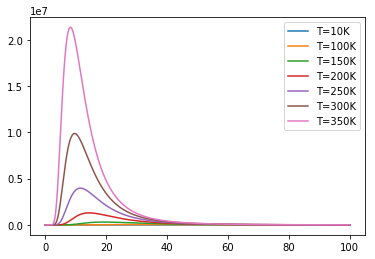

In [4]:
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale) 

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * nd.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = nd.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.asnumpy(), radiance.asnumpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are a fearless physicist measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

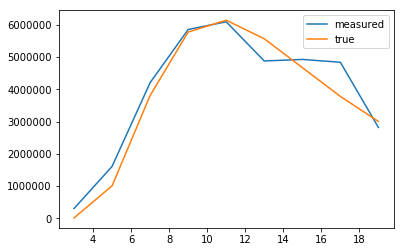

In [5]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = nd.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = nd.random_normal(shape=(len(wavelengths))) * 1

radiance = wien(wavelengths + delta,realtemp)
plt.plot(wavelengths.asnumpy(), radiance.asnumpy(), label='measured')
plt.plot(wavelengths.asnumpy(), wien(wavelengths, realtemp).asnumpy(), label='true')
plt.legend()
plt.show()

Use Gluon to estimate the real temperature based on the variables `wavelengths` and `radiance`. 

* You can use Wien's law implementation `wien(lam,t)` as your forward model. 
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.